# EDA – NIH Chest X-Rays

Main findings:

A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Also, **describe your findings and how will you set up the model training based on the findings.**

## Index

## 1. Import libraries

In [2]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats

from glob import glob
from itertools import chain
from skimage import filters
%matplotlib inline
sns.set_style('white')
plt.rc("axes.spines", top=False, right=False)

## 2. Data loading

In [3]:
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
print('Shape of all_xray_df:', all_xray_df.shape)
all_xray_df.sample(3)

Shape of all_xray_df: (112120, 12)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
40091,00010471_001.png,Cardiomegaly|Effusion|Pneumonia,1,10471,77,F,PA,2530,2581,0.143000,0.143000,NaN
25117,00006613_000.png,No Finding,0,6613,38,M,PA,2500,2048,0.171000,0.171000,NaN
111610,00030561_014.png,Pneumothorax,14,30561,83,F,PA,2021,2021,0.194311,0.194311,NaN


In [4]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
print('Shape of sample_df:', sample_df.shape)
sample_df.sample(3)

Shape of sample_df: (5606, 11)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
5430,00029479_003.png,Infiltration,3,29479,049Y,F,AP,3056,2544,0.139,0.139
3483,00017138_110.png,Infiltration,110,17138,024Y,M,AP,2500,2048,0.168,0.168
3563,00017618_019.png,Cardiomegaly|Consolidation|Effusion|Mass|Pneum...,19,17618,035Y,M,PA,2992,2991,0.143,0.143


### 2.1. Overview of Data_Entry_2017

In [5]:
print(f'Number of entries: {all_xray_df.shape[0]:,.0f}')
print(f'Number of unique images: {all_xray_df["Image Index"].nunique():,.0f}')
print(f'Number of unique patients: {all_xray_df["Patient ID"].nunique():,.0f}')
print(f'Number of unique labels: {all_xray_df["Finding Labels"].nunique():,.0f}')
print(f'Number of unique genders: {all_xray_df["Patient Gender"].nunique():,.0f}')
print(f'Number of unique view positions: {all_xray_df["View Position"].nunique():,.0f}')

Number of entries: 112,120
Number of unique images: 112,120
Number of unique patients: 30,805
Number of unique labels: 836
Number of unique genders: 2
Number of unique view positions: 2


In [6]:
all_xray_df.describe(include='all')

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112120,112120,112120.000000,112120.000000,112120.000000,112120,112120,112120.000000,112120.000000,112120.000000,112120.000000,0.0
unique,112120,836,NaN,NaN,NaN,2,2,NaN,NaN,NaN,NaN,NaN
top,00016092_009.png,No Finding,NaN,NaN,NaN,M,PA,NaN,NaN,NaN,NaN,NaN
freq,1,60361,NaN,NaN,NaN,63340,67310,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,8.573751,14346.381743,46.901463,NaN,NaN,2646.078844,2486.438842,0.155649,0.155649,NaN
std,NaN,NaN,15.406320,8403.876972,16.839923,NaN,NaN,341.246429,401.268227,0.016174,0.016174,NaN
min,NaN,NaN,0.000000,1.000000,1.000000,NaN,NaN,1143.000000,966.000000,0.115000,0.115000,NaN
25%,NaN,NaN,0.000000,7310.750000,35.000000,NaN,NaN,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,NaN,NaN,3.000000,13993.000000,49.000000,NaN,NaN,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,NaN,NaN,10.000000,20673.000000,59.000000,NaN,NaN,2992.000000,2991.000000,0.168000,0.168000,NaN


In [7]:
outliers_age = all_xray_df[all_xray_df['Patient Age'] > 100]
print('Number of outliers with age > 100 years old:', outliers_age.shape[0])
outliers_age

Number of outliers with age > 100 years old: 16


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
20852,00005567_000.png,Effusion|Pneumonia,0,5567,412,M,AP,3056,2544,0.139,0.139,NaN
46965,00011973_002.png,Edema,2,11973,414,M,AP,3056,2544,0.139,0.139,NaN
48284,00012238_010.png,No Finding,10,12238,148,M,PA,2992,2991,0.143,0.143,NaN
55742,00013950_000.png,No Finding,0,13950,148,M,PA,2964,2939,0.143,0.143,NaN
58650,00014520_026.png,Infiltration|Mass,26,14520,150,M,PA,2992,2991,0.143,0.143,NaN
62929,00015558_000.png,No Finding,0,15558,149,M,PA,2992,2991,0.143,0.143,NaN
74884,00018366_044.png,Pneumothorax,44,18366,152,F,PA,2302,2991,0.143,0.143,NaN
78795,00019346_000.png,Infiltration,0,19346,151,F,PA,2678,2774,0.143,0.143,NaN
84810,00020900_002.png,No Finding,2,20900,411,M,AP,3056,2544,0.139,0.139,NaN
85404,00021047_002.png,Mass|Pleural_Thickening,2,21047,412,M,AP,3056,2544,0.139,0.139,NaN


In [8]:
all_xray_df['Unnamed: 11'].value_counts(dropna=False)

NaN    112120
Name: Unnamed: 11, dtype: int64

In [9]:
# Look for NaNs besides the last column
all_xray_df.iloc[:, :-1].isna().any(axis=1).any()

False

There are no NaN entries besides the `Unnamed: 11` column.

### 2.2. Overview of sample_labels.csv

In [10]:
print(f'Number of entries: {sample_df.shape[0]:,.0f}')
print(f'Number of unique images: {sample_df["Image Index"].nunique():,.0f}')
print(f'Number of unique patients: {sample_df["Patient ID"].nunique():,.0f}')
print(f'Number of unique labels: {sample_df["Finding Labels"].nunique():,.0f}')

Number of entries: 5,606
Number of unique images: 5,606
Number of unique patients: 4,230
Number of unique labels: 244


In [11]:
# Look for NaNs
sample_df.isna().any(axis=1).any()

False

## 3. Data cleaning

In [12]:
all_xray_df = all_xray_df.drop(columns='Unnamed: 11')

In [13]:
# Drop outliers with ages higher than 100 years old to avoid biases
# Reason: There are just 16 entries out of 112,120
all_xray_df = all_xray_df.loc[all_xray_df['Patient Age'] <= 100].copy()

## 4. Exploratory Data Analysis

This section explores the following information:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

## 4.1. Patient Demographics

#### 4.1.1. Age

Text(1.1, 95, 'Max: 95.00')

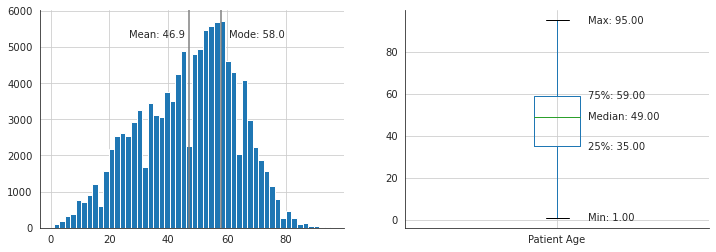

In [14]:
_, ax = plt.subplots(1, 2, figsize=(12, 4))

all_xray_df['Patient Age'].hist(bins=50, ax=ax[0])
all_xray_df.boxplot(column='Patient Age', ax=ax[1])

# Add annotations
min_value = all_xray_df['Patient Age'].min()
p_25 = all_xray_df['Patient Age'].quantile(0.25)
mean_value = all_xray_df['Patient Age'].mean()
median_value = all_xray_df['Patient Age'].median()
p_75 = all_xray_df['Patient Age'].quantile(0.75)
max_value = all_xray_df['Patient Age'].max()
mode_value = all_xray_df['Patient Age'].mode()[0]

ax[0].axvline(mean_value, c='gray')
ax[0].axvline(mode_value, c='gray')
ax[0].annotate(f'Mean: {mean_value:.1f}', (0.18, 0.85), xycoords='figure fraction')
ax[0].annotate(f'Mode: {mode_value:.1f}', (0.32, 0.85), xycoords='figure fraction')

ax[1].text(1.1, median_value, f'Median: {median_value:.2f}', va='center', ha='left')
ax[1].text(1.1, p_25, f'25%: {p_25:.2f}', va='center', ha='left')
ax[1].text(1.1, p_75, f'75%: {p_75:.2f}', va='center', ha='left')
ax[1].text(1.1, min_value, f'Min: {min_value:.2f}', va='center', ha='left')
ax[1].text(1.1, max_value, f'Max: {max_value:.2f}', va='center', ha='left')

#### 4.1.2. Gender

In [15]:
all_xray_df['Patient Gender'].value_counts(normalize=True)

M    0.564904
F    0.435096
Name: Patient Gender, dtype: float64

### 4.2. The X-Rays views taken

In [16]:
all_xray_df['View Position'].value_counts(normalize=True)

PA    0.600326
AP    0.399674
Name: View Position, dtype: float64

### 4.3. Distribution of Pneumonia

#### 4.3.1. Number of Pneumonia cases

In [17]:
all_xray_df['has_pneumonia'] = all_xray_df['Finding Labels'].map(lambda x: 'Pneumonia' in x)
print(f'Number of cases with Pneumonia: ' +
        f'{len(all_xray_df.query("has_pneumonia"))} / {len(all_xray_df)}' +
        f' ({all_xray_df.has_pneumonia.mean()*100:.2f} %)')

Number of cases with Pneumonia: 1430 / 112104 (1.28 %)


#### 4.3.2. Co-occurrence with other diseases

Extract from the column "Finding Labels" all separate diseases:

In [18]:
entry_findings = all_xray_df['Finding Labels'].map(lambda x: x.split('|'))
all_diseases = set(chain.from_iterable(entry_findings.tolist()))
print('Number of findings (including "No finding"):', len(all_diseases))
all_diseases

Number of findings (including "No finding"): 15


{'Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax'}

Next, we build a separate DataFrame to find the co-occurrence matrix and analyse the diseases that are found with Pneumonia.

In [19]:
# Create dataframe with instances of individual findings
diseases = pd.DataFrame(index=all_xray_df.index)
for disease in all_diseases:
    diseases[disease] = all_xray_df['Finding Labels'].map(lambda x: disease in x)

diseases = diseases.astype(np.int64)
diseases.head()

,Infiltration,Hernia,Pneumonia,Fibrosis,Effusion,Pleural_Thickening,Edema,Emphysema,Pneumothorax,Atelectasis,Nodule,Consolidation,Mass,Cardiomegaly,No Finding
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
assert (
    'Emphysema' in all_xray_df.iloc[1]['Finding Labels'] and
    'Cardiomegaly' in all_xray_df.iloc[1]['Finding Labels']
)

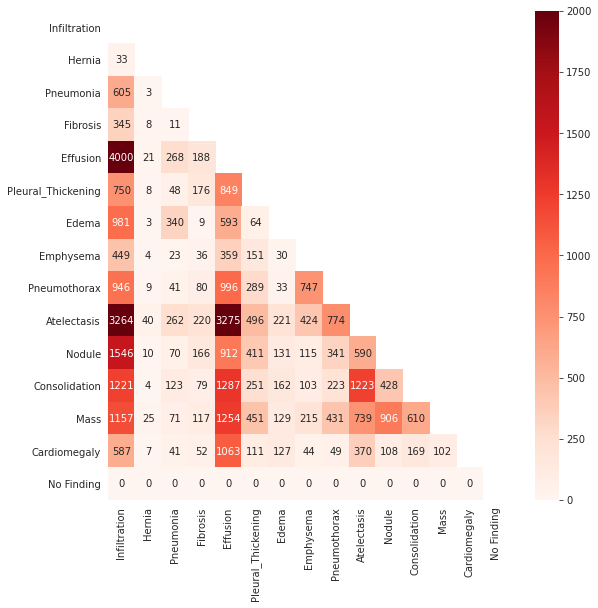

In [21]:
# Generate the co-occurrence matrix
coocc = diseases.T.dot(diseases)
plt.figure(figsize=(9,9))
sns.heatmap(coocc, cmap='Reds', annot=True, mask=np.triu(np.ones_like(coocc)), vmin=0, vmax=2000, fmt='.0f')

In [22]:
# Validation checks
assert diseases.query('Atelectasis == 1 and Infiltration == 1').shape[0] == 3264
assert diseases.query('Effusion == 1 and Pleural_Thickening == 1').shape[0] == 849
assert (diseases.query('`No Finding` == 1').sum(axis=1) == 1).all()  # `No Finding` appears alone
assert diseases.query('Pneumonia == 1').shape[0] == 1430

From the heatmap above, we can observe that Pneumonia is often found with Infiltration, Edema, Effusion, and Atelectasis. The bar plot below illustrates this fact clearly:

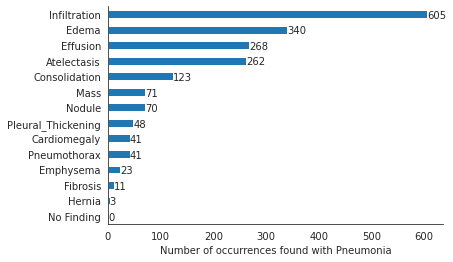

In [23]:
ax = coocc.loc['Pneumonia', coocc.columns != 'Pneumonia'].sort_values().plot(kind='barh')
ax.set_xlabel('Number of occurrences found with Pneumonia')
for p in ax.patches:
    ax.annotate(p.get_width(), (p.get_width(), p.get_y()))

In [24]:
ratio = (
    diseases.query('Pneumonia == 1 and Infiltration == 1').shape[0] / 
    diseases.query('Pneumonia == 1').shape[0]
)
print(f'Proportion of Pneumonia cases with Infiltration: {ratio*100:,.1f}%')

Proportion of Pneumonia cases with Infiltration: 42.3%


Finally, let's evaluate the number of diseases found with Pneumonia in the dataset:

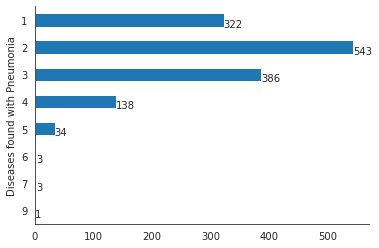

In [25]:
ax = (
    diseases.query('Pneumonia == 1').sum(axis=1)
    .value_counts()
    .sort_index(ascending=False)
    .plot(kind='barh')
)
ax.set_ylabel('Diseases found with Pneumonia')
for p in ax.patches:
    ax.annotate(p.get_width(), (p.get_width(), p.get_y()))

So, about one third of Pneumonia cases (N=543) appear with another disease. Then, a quarter of Pneumonia cases appear either alone (N=322) or with two other diseases (N=386).

In [26]:
# Let's find out which are the most common tuples reported with Pneumonia
all_xray_df.query('has_pneumonia').loc[:, 'Finding Labels'].value_counts().head(5)

Pneumonia                       322
Infiltration|Pneumonia          199
Edema|Infiltration|Pneumonia    137
Atelectasis|Pneumonia           108
Edema|Pneumonia                  83
Name: Finding Labels, dtype: int64

In [27]:
# Validate: how many cases of Pneumonia-only findings we have
all_xray_df.query('`Finding Labels` == "Pneumonia"').shape[0]

322

#### 4.3.3. Number of diseases per patient

In [28]:
print(f'Number of patients without any disease: '+
      f'{diseases.query("`No Finding` == 1").shape[0]:,.0f} / {diseases.shape[0]:,.0f}'+
      f' ({diseases.query("`No Finding` == 1").shape[0] / diseases.shape[0] * 100:,.0f}%)') 

Number of patients without any disease: 60,353 / 112,104 (54%)


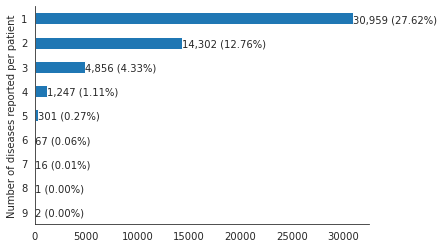

In [29]:
ax = (
    diseases.query('`No Finding` == 0').sum(axis=1)
    .value_counts(normalize=False)
    .sort_index(ascending=False)
    .plot(kind='barh',)
)
ax.set_ylabel('Number of diseases reported per patient')
N_all = diseases.shape[0]
for p in ax.patches:
    ax.annotate(f'{p.get_width():,.0f} ({p.get_width()/N_all*100:.2f}%)', 
                (p.get_width(), p.get_y()), ha='left', va='bottom')

### 4.4. Pixel-level assessments

This section explores images and pixel distributions of images with:
- No findings
- Pneumonia
- Infiltration
- Edema
- Effusion
- Atelectasis

For each of these diseases, the analysis also explores differences in View Position (AP vs PA).

In [30]:
sample_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


In [39]:
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}


def mean_and_std(pixel_array): 
    return pixel_array.mean(), pixel_array.std()


def standardise_image(image):
    mean, std = mean_and_std(image)
    new_img = image.copy()
    return (new_img - mean) / std 


def norm_image(image):
    new_img = image.copy()
    return new_img / 255

def load_img(img_path):
    img = plt.imread(img_path, format='PNG')
    return img


def plot_img(img, ax):
    ax.imshow(img, cmap='gray')

    
def plot_intensities(img, ax):
    ax.hist(img, range=(0, 1))
    ax.axvline(img.mean(), c='gray')
    ax.annotate(f'mean={img.mean():.2f}', (0.05, 0.7), xycoords='axes fraction', ha='left')
    ax.annotate(f'std={img.std():.2f}', (0.05, 0.5), xycoords='axes fraction', ha='left')
    ax.annotate(f'75%={np.percentile(img, 75):.2f}', (0.05, 0.3), xycoords='axes fraction', ha='left')

In [40]:
def plot_samples(df, N_SAMPLES=6):
    images_ap = df.query('`View Position` == "AP"').loc[:, 'Image Index'].sample(N_SAMPLES)
    images_pa = df.query('`View Position` == "PA"').loc[:, 'Image Index'].sample(N_SAMPLES)

    fig, ax = plt.subplots(N_SAMPLES, 4, figsize=(12, 12))
    plt.subplots_adjust(wspace=0,)
    fig.suptitle('Images and intensities (STD) - Order AP-PA')
    for i in range(N_SAMPLES):
        img_ap = load_img(all_image_paths[images_ap.iloc[i]])
        img_pa = load_img(all_image_paths[images_pa.iloc[i]])

        plot_img(img_ap, ax[i, 0])
        plot_img(img_pa, ax[i, 1])

        # Apply Otsu mask
        val_ap = filters.threshold_otsu(img_ap)
        val_pa = filters.threshold_otsu(img_pa)    
        img_ap = img_ap[img_ap > val_ap]
        img_pa = img_pa[img_pa > val_pa]    

        # Plot intensities
        img_ap_norm = norm_image(img_ap)
        img_pa_norm = norm_image(img_pa)
        plot_intensities(img_ap_norm, ax[i, 2])
        plot_intensities(img_pa_norm, ax[i, 3])
        ax[i, 0].axis('off')
        ax[i, 1].axis('off')
        ax[i, 2].set_yticks([])
        ax[i, 3].set_yticks([])    

#### 4.4.1. Images with no findings

In [41]:
images_no_findings = sample_df.query('`Finding Labels` == "No Finding"')
images_no_findings.shape

(3044, 11)

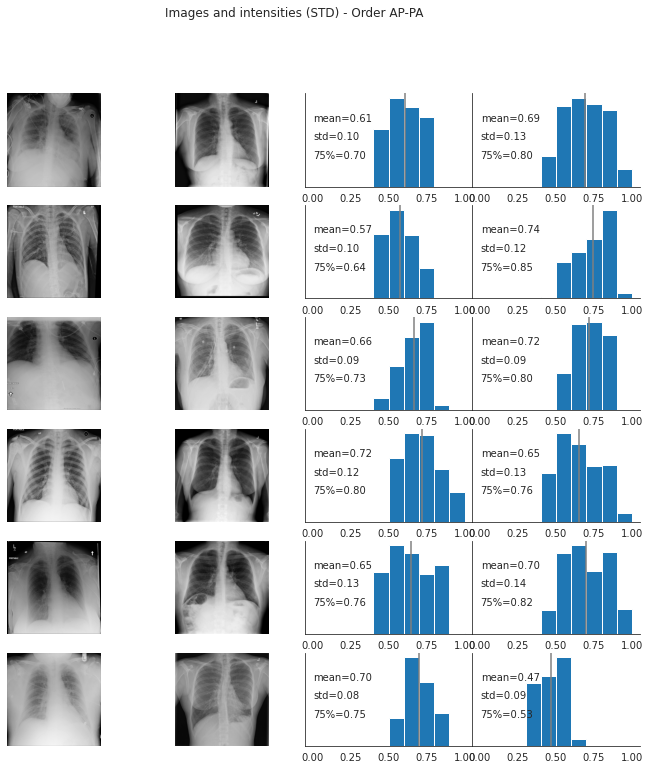

In [42]:
plot_samples(df=images_no_findings, N_SAMPLES=6)

#### 4.4.2. Images with only Pneumonia

In [43]:
samples_with_pneumonia = sample_df.query('`Finding Labels` == "Pneumonia"')
samples_with_pneumonia.shape

(14, 11)

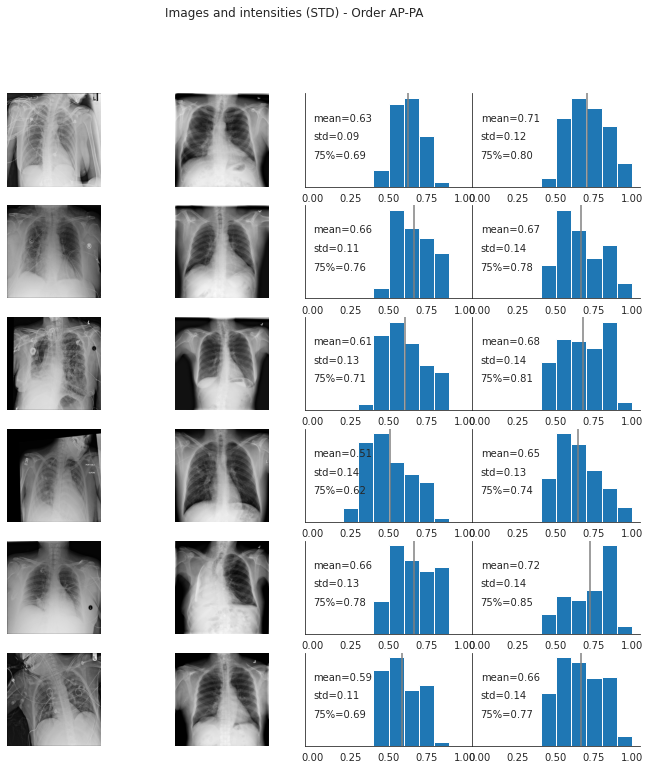

In [44]:
plot_samples(df=samples_with_pneumonia, N_SAMPLES=6)

#### 4.4.3. Images with Pneumonia and Infiltration

In [45]:
sample_df['pneumonia_and_infiltration'] = sample_df['Finding Labels'].map(
    lambda x: 'Infiltration' in x and 'Pneumonia' in x
)
samples_with_pneumonia_and_inf = sample_df.query('pneumonia_and_infiltration')
samples_with_pneumonia_and_inf.shape

(23, 12)

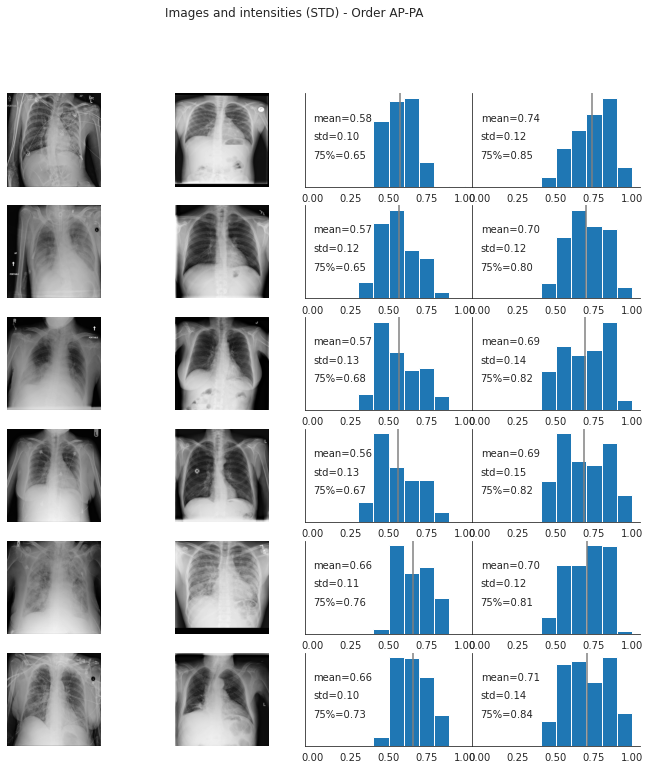

In [46]:
plot_samples(df=samples_with_pneumonia_and_inf, N_SAMPLES=6)

#### 4.4.4. Images with  Edema

In [47]:
sample_df['edema'] = sample_df['Finding Labels'].map(
    lambda x: 'Edema' in x
)
samples_with_edema = sample_df.query('edema')
samples_with_edema.shape

(118, 13)

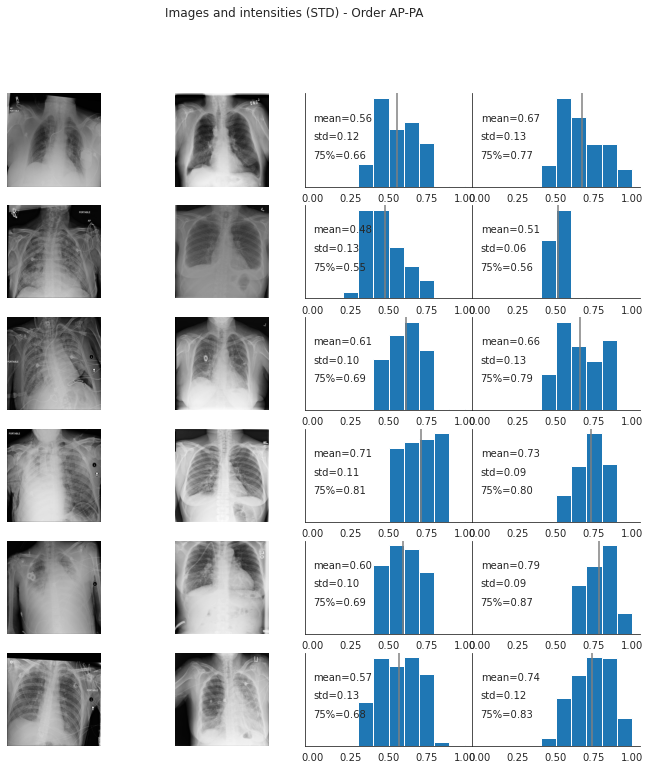

In [48]:
plot_samples(df=samples_with_edema, N_SAMPLES=6)

#### 4.4.5. Images with Effusion

In [49]:
sample_df['effusion'] = sample_df['Finding Labels'].map(
    lambda x: 'Effusion' in x
)
samples_with_effusion = sample_df.query('effusion')
samples_with_effusion.shape

(644, 14)

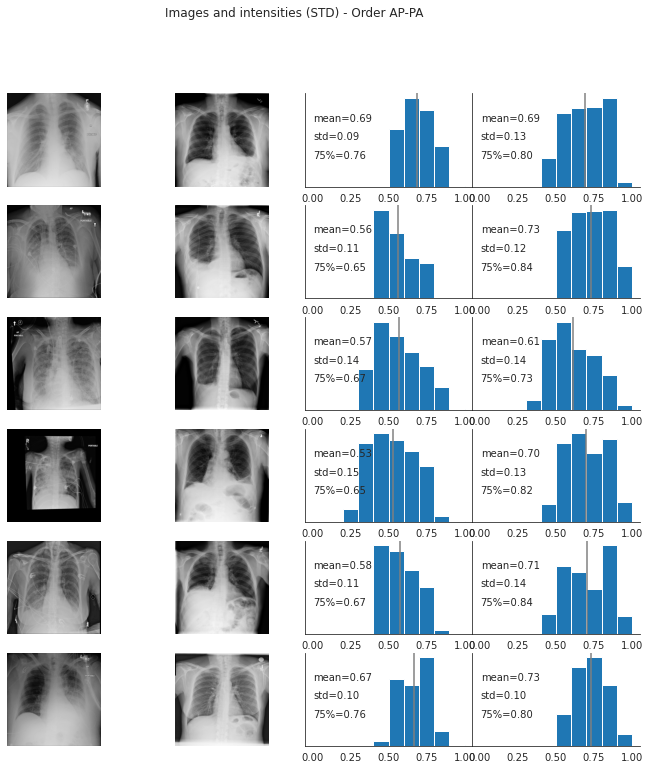

In [50]:
plot_samples(df=samples_with_effusion, N_SAMPLES=6)

#### 4.4.6. Images with Atelectasis

In [51]:
sample_df['atelectasis'] = sample_df['Finding Labels'].map(
    lambda x: 'Atelectasis' in x
)
samples_with_atelectasis = sample_df.query('atelectasis')
samples_with_atelectasis.shape

(508, 15)

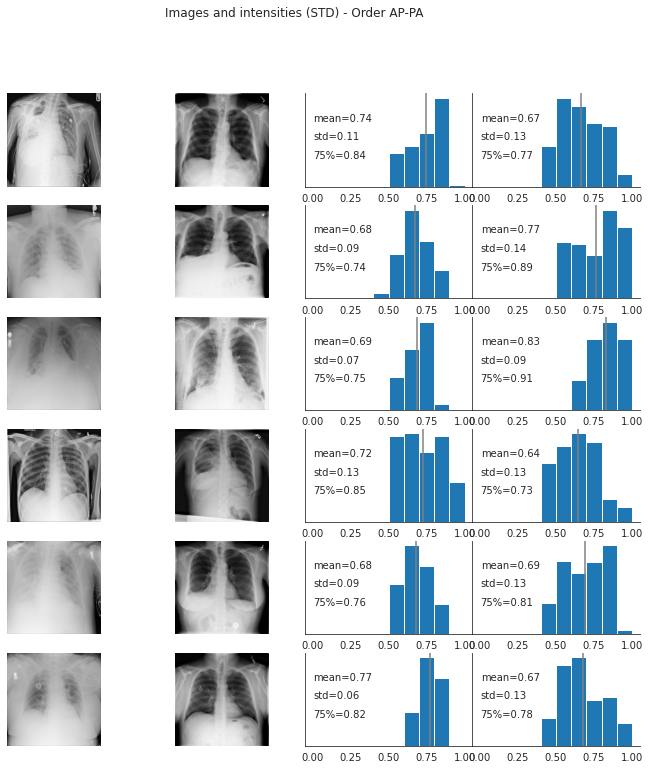

In [52]:
plot_samples(df=samples_with_atelectasis, N_SAMPLES=6)